# Trabajo Final ClusterAI 2020 - Grupo 1

### Ciencia de Datos - Ingenieria Industrial UTN BA

#### Alumnos: Tomas Ambrogi y Solange Suli

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

#### Es importante correr previamente la notebook ["Preprocesamiento" ](https://github.com/tomiambro/clusterai2020_grupo1/blob/master/Preprocesamiento.ipynb) para achicar el dataset original filtrando únicamente los casos de CABA

In [2]:
df_caba = pd.read_feather('./data/CovidCabaFeather')
df_caba.head()

,index,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,...,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id
0,0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaT,...,NO,NaT,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0
1,6,1000008,F,69.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-31,...,NO,NaT,NO,2,Privado,Caso Descartado,Descartado,2,2020-06-01,0
2,8,1000010,M,7.0,Años,Argentina,CABA,COMUNA 07,CABA,NaT,...,NO,NaT,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,2,2020-06-01,7
3,10,1000012,M,46.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-26,...,NO,NaT,NO,2,Privado,Caso confirmado por laboratorio - No Activo po...,Confirmado,2,2020-05-31,0
4,13,1000015,F,29.0,Años,Argentina,CABA,COMUNA 07,Buenos Aires,2020-05-18,...,NO,NaT,NO,6,Privado,Caso confirmado por laboratorio - No activo (p...,Confirmado,2,2020-06-01,7


### Unificamos la escala de edades

Dividimos las edades en meses por 12 asi medimos todo en años

In [3]:
df_caba.loc[df_caba.edad_años_meses == 'Meses', 'edad'] = df_caba.edad / 12
df_caba.loc[df_caba.edad_años_meses == 'Meses',:].tail()
df_caba.head()

,index,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,...,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id
0,0,1000000,M,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaT,...,NO,NaT,NO,6,Privado,Caso Descartado,Descartado,2,2020-06-09,0
1,6,1000008,F,69.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-31,...,NO,NaT,NO,2,Privado,Caso Descartado,Descartado,2,2020-06-01,0
2,8,1000010,M,7.0,Años,Argentina,CABA,COMUNA 07,CABA,NaT,...,NO,NaT,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,2,2020-06-01,7
3,10,1000012,M,46.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-26,...,NO,NaT,NO,2,Privado,Caso confirmado por laboratorio - No Activo po...,Confirmado,2,2020-05-31,0
4,13,1000015,F,29.0,Años,Argentina,CABA,COMUNA 07,Buenos Aires,2020-05-18,...,NO,NaT,NO,6,Privado,Caso confirmado por laboratorio - No activo (p...,Confirmado,2,2020-06-01,7


Con las edades unificadas removemos la columna 'edad_años_meses' y aprovechamos para sacar tambien las columnas 'residencia_provincia_nombre', 'sepi_apertura' (semana epidemiologica), 'carga_provincia_id', 'residencia_provincia_id','residencia_departamento_id' (solo vamos a usar los datos de CABA) e 'id_evento_caso'.

In [4]:
df_caba = df_caba.drop(['index', 'edad_años_meses', 'residencia_provincia_nombre','sepi_apertura',
                       'carga_provincia_id','residencia_provincia_id','residencia_pais_nombre','residencia_departamento_nombre', 'id_evento_caso'], axis=1)

df_caba.tail()

,sexo,edad,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,fecha_internacion,cuidado_intensivo,fecha_cui_intensivo,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,clasificacion_resumen,fecha_diagnostico,residencia_departamento_id
361128,F,27.0,CABA,2020-05-15,2020-06-01,NaT,NO,NaT,NO,NaT,NO,Público,Caso Descartado,Descartado,2020-06-01,0
361129,M,38.0,Tucumán,NaT,2020-06-01,NaT,NO,NaT,NO,NaT,NO,Público,Caso Descartado,Descartado,2020-06-02,0
361130,F,50.0,CABA,2020-05-28,2020-06-01,2020-05-31,NO,NaT,NO,NaT,NO,Privado,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-06-01,0
361131,M,42.0,CABA,NaT,2020-06-01,NaT,NO,NaT,NO,NaT,NO,Privado,Caso Descartado,Descartado,2020-06-01,0
361132,F,30.0,Córdoba,NaT,2020-06-01,NaT,NO,NaT,NO,NaT,NO,Público,Caso Descartado,Descartado,2020-06-02,0


#### Modificamos las columnas de 'fallecido', 'cuidado_intensivo' y 'asistencia_respiratoria' con strings 'SI'/'NO' por variables booleanas.

In [5]:
df_caba.fallecido = pd.Categorical(df_caba.fallecido)
df_caba.fallecido = df_caba.fallecido.cat.codes

df_caba.cuidado_intensivo = pd.Categorical(df_caba.cuidado_intensivo)
df_caba.cuidado_intensivo = df_caba.cuidado_intensivo.cat.codes

df_caba.asistencia_respiratoria_mecanica = pd.Categorical(df_caba.asistencia_respiratoria_mecanica)
df_caba.asistencia_respiratoria_mecanica = df_caba.asistencia_respiratoria_mecanica.cat.codes

df_caba.origen_financiamiento = pd.Categorical(df_caba.origen_financiamiento)
df_caba.origen_financiamiento = df_caba.origen_financiamiento.cat.codes

### Ordenamos los datos de acuerdo a la fecha de apertura


In [40]:
df_caba = df_caba.sort_values(by='fecha_apertura')
df_caba.reset_index(inplace=True,drop=True)
df_caba.tail()

,sexo,edad,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,fecha_internacion,cuidado_intensivo,fecha_cui_intensivo,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,clasificacion_resumen,fecha_diagnostico,residencia_departamento_id,presenta_sintomas,requiere_internacion
361128,F,31.0,Buenos Aires,2020-09-25,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso Descartado,Descartado,2020-10-01,15,True,False
361129,F,23.0,CABA,NaT,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-09-30,0,False,False
361130,F,19.0,CABA,2020-09-29,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso Descartado,Descartado,2020-10-01,0,True,False
361131,M,43.0,Buenos Aires,2020-09-27,2020-09-30,NaT,0,NaT,0,NaT,0,1,Caso Descartado,Descartado,2020-10-01,0,True,False
361132,F,21.0,CABA,NaT,2020-09-30,NaT,0,NaT,0,NaT,0,1,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-09-30,1,False,False


### Chequeamos valores nulos por columna

In [7]:
df_caba.isnull().sum()

sexo                                     0
edad                                   256
carga_provincia_nombre                   0
fecha_inicio_sintomas               189734
fecha_apertura                           0
fecha_internacion                   317362
cuidado_intensivo                        0
fecha_cui_intensivo                 356249
fallecido                                0
fecha_fallecimiento                 355767
asistencia_respiratoria_mecanica         0
origen_financiamiento                    0
clasificacion                            0
clasificacion_resumen                    0
fecha_diagnostico                    34788
residencia_departamento_id               0
dtype: int64

### Transformamos 'fecha_inicio_sintomas' y 'fecha_internacion' en variables booleanas --> en nuevas columnas: 'presenta_sintomas' y 'requiere_internacion'


In [8]:
df_caba['presenta_sintomas'] = df_caba['fecha_inicio_sintomas'].notnull()
df_caba['requiere_internacion'] = df_caba['fecha_internacion'].notnull()
df_caba

,sexo,edad,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,fecha_internacion,cuidado_intensivo,fecha_cui_intensivo,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,clasificacion_resumen,fecha_diagnostico,residencia_departamento_id,presenta_sintomas,requiere_internacion
0,F,41.0,CABA,2020-01-23,2020-01-31,NaT,0,NaT,0,NaT,0,1,Caso Invalidado Epidemiologicamente,Descartado,NaT,12,True,False
1,F,34.0,CABA,2020-01-16,2020-01-31,NaT,0,NaT,0,NaT,0,0,Caso Descartado,Descartado,2020-02-11,0,True,False
2,F,31.0,CABA,NaT,2020-01-31,NaT,0,NaT,0,NaT,0,0,Caso Descartado,Descartado,2020-02-11,0,False,False
3,M,29.0,CABA,2020-02-03,2020-02-05,NaT,0,NaT,0,NaT,0,1,Otro diagnostico,Descartado,NaT,11,True,False
4,F,32.0,CABA,NaT,2020-02-26,NaT,0,NaT,0,NaT,0,0,Caso Invalidado Epidemiologicamente,Descartado,NaT,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361128,M,60.0,CABA,2020-09-19,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-10-01,0,True,False
361129,M,45.0,CABA,2020-09-26,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-10-01,0,True,False
361130,F,55.0,CABA,NaT,2020-09-30,2020-09-30,0,NaT,0,NaT,0,1,Caso Descartado,Descartado,2020-09-30,4,False,True
361131,M,15.0,CABA,NaT,2020-09-30,NaT,0,NaT,0,NaT,0,0,Caso Descartado,Descartado,2020-09-30,0,False,False


### Creamos un df unicamente con casos CONFIRMADOS de CABA

In [9]:
df_confirmados = pd.DataFrame(df_caba.loc[df_caba.clasificacion_resumen == 'Confirmado'])
df_confirmados.reset_index(inplace=True,drop=True)
df_confirmados.head() #notar que el primer caso confirmado fue el 02-03-2020

,sexo,edad,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,fecha_internacion,cuidado_intensivo,fecha_cui_intensivo,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,clasificacion_resumen,fecha_diagnostico,residencia_departamento_id,presenta_sintomas,requiere_internacion
0,M,43.0,CABA,2020-02-28,2020-03-02,2020-03-01,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-03,1,True,True
1,M,24.0,CABA,2020-03-01,2020-03-05,2020-03-03,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-11,13,True,True
2,M,47.0,CABA,2020-03-03,2020-03-05,2020-03-03,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-03-06,3,True,True
3,F,72.0,CABA,2020-03-04,2020-03-05,NaT,0,NaT,0,NaT,0,1,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-06,7,True,False
4,M,45.0,CABA,2020-03-04,2020-03-05,NaT,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-03-06,5,True,False


## Evaluamos datos faltantes por columnas de Datos Confirmados


In [11]:
df_confirmados.isnull().sum()

sexo                                     0
edad                                    37
carga_provincia_nombre                   0
fecha_inicio_sintomas                47648
fecha_apertura                           0
fecha_internacion                   107319
cuidado_intensivo                        0
fecha_cui_intensivo                 124735
fallecido                                0
fecha_fallecimiento                 122894
asistencia_respiratoria_mecanica         0
origen_financiamiento                    0
clasificacion                            0
clasificacion_resumen                    0
fecha_diagnostico                      635
residencia_departamento_id               0
presenta_sintomas                        0
requiere_internacion                     0
dtype: int64


## ¿Qué hacemos con los datos faltantes?

- edad --> se descartan esos datos particulares (son muy pocos en comparacion a la cantidad de datos totales (127054) )

In [12]:
# Eliminamos datos faltantes de 'edad'
df_confirmados = df_confirmados.drop(df_confirmados.loc[df_confirmados.edad.isnull(),:].index)

In [13]:
df_confirmados.sexo = pd.Categorical(df_confirmados.sexo)
df_confirmados.sexo = df_confirmados.sexo.cat.codes
df_confirmados.head()

,sexo,edad,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,fecha_internacion,cuidado_intensivo,fecha_cui_intensivo,fallecido,fecha_fallecimiento,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,clasificacion_resumen,fecha_diagnostico,residencia_departamento_id,presenta_sintomas,requiere_internacion
0,1,43.0,CABA,2020-02-28,2020-03-02,2020-03-01,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-03,1,True,True
1,1,24.0,CABA,2020-03-01,2020-03-05,2020-03-03,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-11,13,True,True
2,1,47.0,CABA,2020-03-03,2020-03-05,2020-03-03,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-03-06,3,True,True
3,0,72.0,CABA,2020-03-04,2020-03-05,NaT,0,NaT,0,NaT,0,1,Caso confirmado por laboratorio - No Activo po...,Confirmado,2020-03-06,7,True,False
4,1,45.0,CABA,2020-03-04,2020-03-05,NaT,0,NaT,0,NaT,0,0,Caso confirmado por laboratorio - No activo (p...,Confirmado,2020-03-06,5,True,False


## Analizamos si la muerte se produce _por_ covid o _con_ covid

Para eso, nos fijamos si existen registros de personas fallecidas que nunca presentaron sintomas

In [14]:
df_confirmados = df_confirmados.drop(df_confirmados.loc[(df_confirmados['fallecido'] == True) & (df_confirmados['presenta_sintomas'] == False), :].index)

In [15]:
df_confirmados.columns

Index(['sexo', 'edad', 'carga_provincia_nombre', 'fecha_inicio_sintomas',
       'fecha_apertura', 'fecha_internacion', 'cuidado_intensivo',
       'fecha_cui_intensivo', 'fallecido', 'fecha_fallecimiento',
       'asistencia_respiratoria_mecanica', 'origen_financiamiento',
       'clasificacion', 'clasificacion_resumen', 'fecha_diagnostico',
       'residencia_departamento_id', 'presenta_sintomas',
       'requiere_internacion'],
      dtype='object')

In [16]:
df_confirmados = df_confirmados.drop(['carga_provincia_nombre', 'fecha_inicio_sintomas', 'fecha_apertura',
                                      'fecha_internacion', 'fecha_cui_intensivo',
                                      'fecha_fallecimiento', 'fecha_diagnostico', 'clasificacion_resumen'], axis=1)

In [17]:
df_confirmados.tail()

,sexo,edad,cuidado_intensivo,fallecido,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,residencia_departamento_id,presenta_sintomas,requiere_internacion
127049,0,41.0,0,0,0,0,Caso confirmado por laboratorio - No activo (p...,0,False,False
127050,0,78.0,0,0,0,0,Caso confirmado por laboratorio - No activo (p...,0,True,False
127051,1,60.0,0,0,0,0,Caso confirmado por laboratorio - No activo (p...,0,True,False
127052,1,45.0,0,0,0,0,Caso confirmado por laboratorio - No activo (p...,0,True,False
127053,0,21.0,0,0,0,1,Caso confirmado por laboratorio - No activo (p...,1,False,False


### Analizamos los distintos casos de 'clasificacion'

In [18]:
df_confirmados.clasificacion.unique()

array(['Caso confirmado por laboratorio - No Activo por criterio de laboratorio',
       'Caso confirmado por laboratorio - No activo (por tiempo de evolución)',
       'Caso confirmado por laboratorio - Fallecido',
       'Caso confirmado por laboratorio - Activo Internado',
       'Caso confirmado por laboratorio - Activo',
       'Caso confirmado por criterio clínico - epidemiológico -  Activo internado',
       'Caso confirmado por criterio clínico-epidemiológico  - No activo (por tiempo de evolución)',
       'Caso confirmado por criterio clínico-epidemiologico - Fallecido'],
      dtype=object)

Vemos que existen valores que mapean directamente a la variable dependiente 'fallecidos' por lo que las renombramos 

In [19]:
df_confirmados.loc[(df_confirmados.clasificacion == 'Caso confirmado por laboratorio - Fallecido'), 'clasificacion'] = 'Caso confirmado por laboratorio - Activo Internado'

df_confirmados.loc[(df_confirmados.clasificacion == 'Caso confirmado por criterio clínico-epidemiologico - Fallecido'), 'clasificacion'] = 'Caso confirmado por criterio clínico - epidemiológico -  Activo internado'

In [20]:
df_confirmados.clasificacion.unique()

array(['Caso confirmado por laboratorio - No Activo por criterio de laboratorio',
       'Caso confirmado por laboratorio - No activo (por tiempo de evolución)',
       'Caso confirmado por laboratorio - Activo Internado',
       'Caso confirmado por laboratorio - Activo',
       'Caso confirmado por criterio clínico - epidemiológico -  Activo internado',
       'Caso confirmado por criterio clínico-epidemiológico  - No activo (por tiempo de evolución)'],
      dtype=object)

Pasamos esa feature a una variable numerica

In [22]:
df_confirmados.clasificacion = pd.Categorical(df_confirmados.clasificacion)
df_confirmados.clasificacion = df_confirmados.clasificacion.cat.codes

## Creamos un dataset unicamente con los sintomaticos

In [23]:
df_sintomas = df_confirmados.loc[df_confirmados['presenta_sintomas'] == True, :]
df_sintomas = df_sintomas.drop('presenta_sintomas', axis=1)
df_sintomas

,sexo,edad,cuidado_intensivo,fallecido,asistencia_respiratoria_mecanica,origen_financiamiento,clasificacion,residencia_departamento_id,requiere_internacion
0,1,43.0,0,0,0,0,4,1,True
1,1,24.0,0,0,0,0,4,13,True
2,1,47.0,0,0,0,0,5,3,True
3,0,72.0,0,0,0,1,4,7,False
4,1,45.0,0,0,0,0,5,5,False
...,...,...,...,...,...,...,...,...,...
127034,0,24.0,0,0,0,0,5,0,False
127039,0,26.0,0,0,0,1,5,4,False
127050,0,78.0,0,0,0,0,5,0,False
127051,1,60.0,0,0,0,0,5,0,False


In [24]:
df_sintomas.columns

Index(['sexo', 'edad', 'cuidado_intensivo', 'fallecido',
       'asistencia_respiratoria_mecanica', 'origen_financiamiento',
       'clasificacion', 'residencia_departamento_id', 'requiere_internacion'],
      dtype='object')

### Analizamos la proporcion de las clases

In [25]:
d = pd.get_dummies(df_sintomas.fallecido)
d.describe()

,0,1
count,79390.000000,79390.000000
mean,0.953999,0.046001
std,0.209488,0.209488
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


Se puede ver que existe un gran desbalance entre las clases

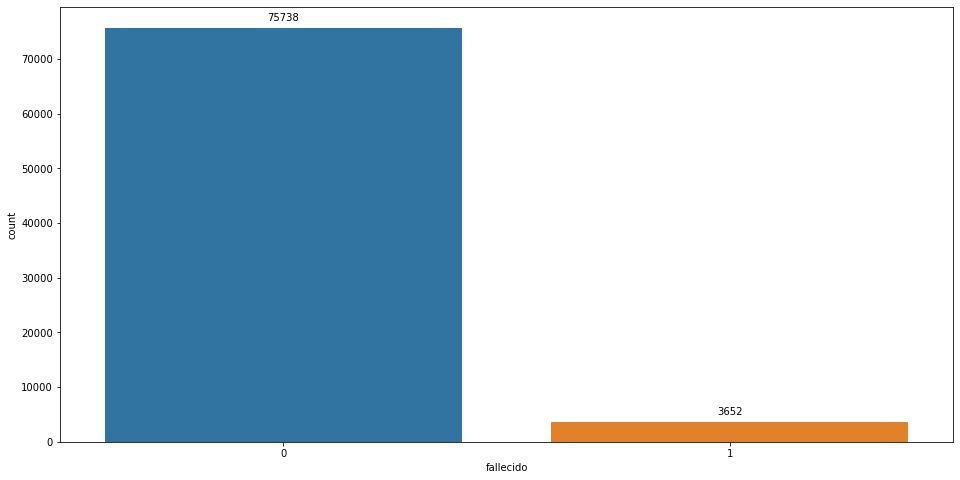

In [42]:
plt.figure(figsize=(16,8))
splot = sns.countplot(x='fallecido', data=df_sintomas)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [27]:
df = df_sintomas.reset_index()
df.to_feather('./data/sintomas_data')

### Particionamos el dataset en train y test

In [28]:
X = df_sintomas.drop('fallecido', axis=1)
y = df_sintomas.fallecido

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

Verificamos que la proporcion en el test sea igual a la del dataset original

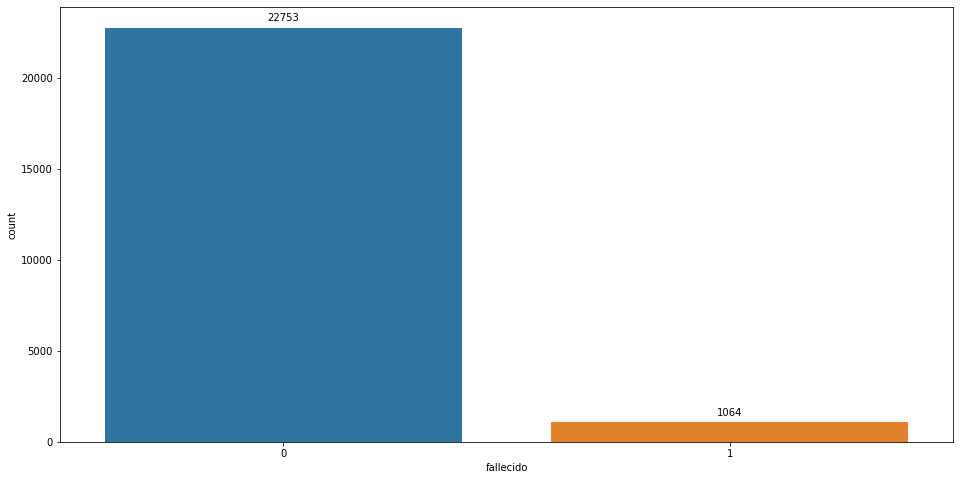

In [35]:
df = pd.DataFrame(xtest)
df = pd.concat([df, ytest], axis=1)

plt.figure(figsize=(16,8))
splot = sns.countplot(x='fallecido', data=df)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [44]:
d = pd.get_dummies(df.fallecido)
d.describe()

,0,1
count,23817.000000,23817.000000
mean,0.955326,0.044674
std,0.206591,0.206591
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


## Baseline Model

Nuestras metricas de interes van a ser el area bajo la curva ROC y el F1 score

In [29]:
lr = LogisticRegression()
lr.fit(xtrain, ytrain)
ypred = lr.predict(xtest)
print(f'AUC ROC: {roc_auc_score(ytest, ypred)}, F1 Score: {f1_score(ytest, ypred)}')

AUC ROC: 0.7925433446932059, F1 Score: 0.6398390342052315


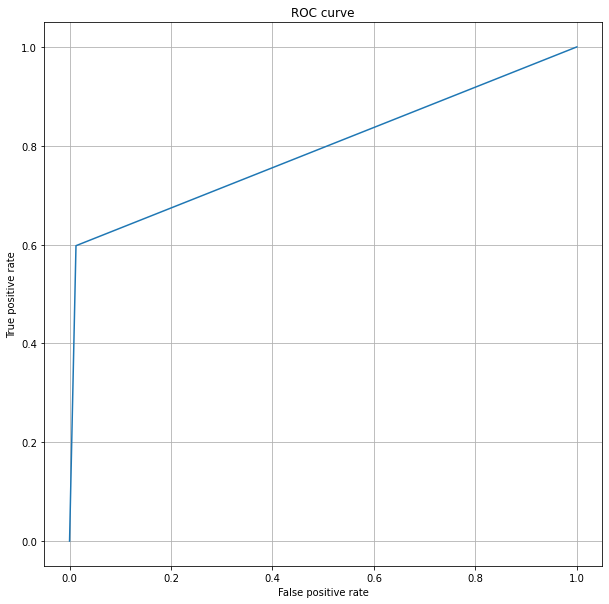

In [30]:
fpr, tpr, _ = roc_curve(ytest, ypred)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.grid(True)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Otros Modelos

In [31]:
res = pd.DataFrame({'model':[], 'roc validation':[], 'roc test':[], 'f1 test':[]})

In [43]:
models = {
        'Logistic Regression': LogisticRegression(n_jobs = 4, random_state=1),
        'Random Forest': RandomForestClassifier(n_jobs = 4, random_state=1),
        'SVC': SVC(random_state=1),
        'KNNeighbors': KNeighborsClassifier(n_jobs = 4)
}

params_RF = {
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features': ['auto', 'log2', 'sqrt'],
}
params_LR = {
    'fit_intercept': [True, False]
}

params_KNR = {
    'n_neighbors': [2, 5, 7, 9],
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'leaf_size': [2, 3, 5, 10, 30, 50]
}

params_SVC = {
    'kernel': ['linear', 'rbf'],
    'C': [0.5, 1],
}

params = {'Logistic Regression': params_LR, 'KNNeighbors': params_KNR,
          'SVC': params_SVC, 'Random Forest': params_RF}


In [33]:
ypreds = {}
m = {}

for name, model in models.items():
    
    # Model training with cross validation
    gs = GridSearchCV(model, cv=3, param_grid=params[name], refit=True, scoring='roc_auc', n_jobs=4)
    gs.fit(xtrain, ytrain)
    print(f'{name}: {gs.best_params_}')
    
    ypred = gs.best_estimator_.predict(xtest)
    ypreds[name] = ypred
    m[name] = gs.best_estimator_
    
    # Save the results to a dataframe
    res = res.append({'model': f"{name}", 'roc validation': gs.best_score_, 'roc test': roc_auc_score(ytest, ypreds[name]), 'f1 test': f1_score(ytest, ypreds[name])}, ignore_index=True)

Logistic Regression: {'fit_intercept': True}
Random Forest: {'max_features': 'log2', 'min_samples_leaf': 5}
SVC: {'C': 1, 'kernel': 'linear'}
KNNeighbors: {'leaf_size': 30, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


## Resultados

In [34]:
res.sort_values('roc validation', ascending=False)

,model,roc validation,roc test,f1 test
1,Random Forest,0.985536,0.835425,0.694656
0,Logistic Regression,0.983071,0.792543,0.639839
2,SVC,0.982801,0.806746,0.649174
3,KNNeighbors,0.953978,0.793294,0.632360


### Area bajo la curva ROC

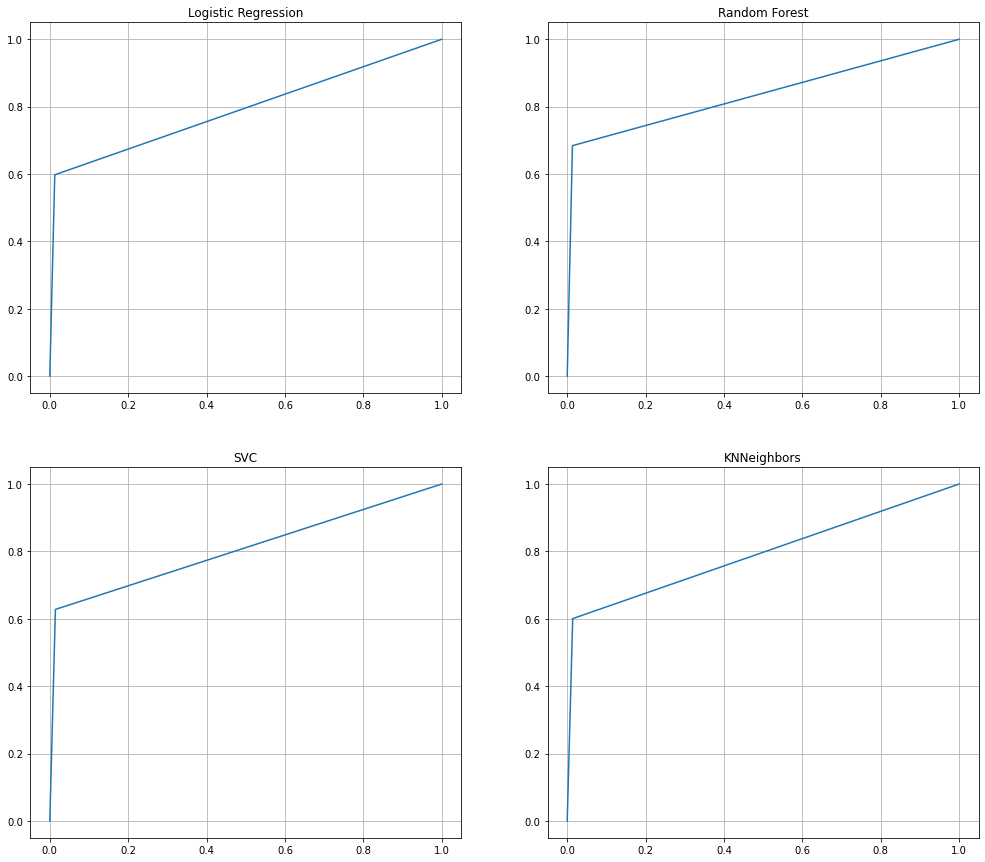

In [36]:
i = 0
names = ['Logistic Regression','Random Forest','SVC','KNNeighbors']

fig, axs = plt.subplots(2, 2, figsize=(17, 15))

for ax in axs.flat:
    fpr, tpr, _ = roc_curve(ytest, ypreds[names[i]])
    ax.plot(fpr, tpr)
    ax.grid(True)
    ax.set_title(f'{names[i]}')
    i += 1

### Matriz de confusion

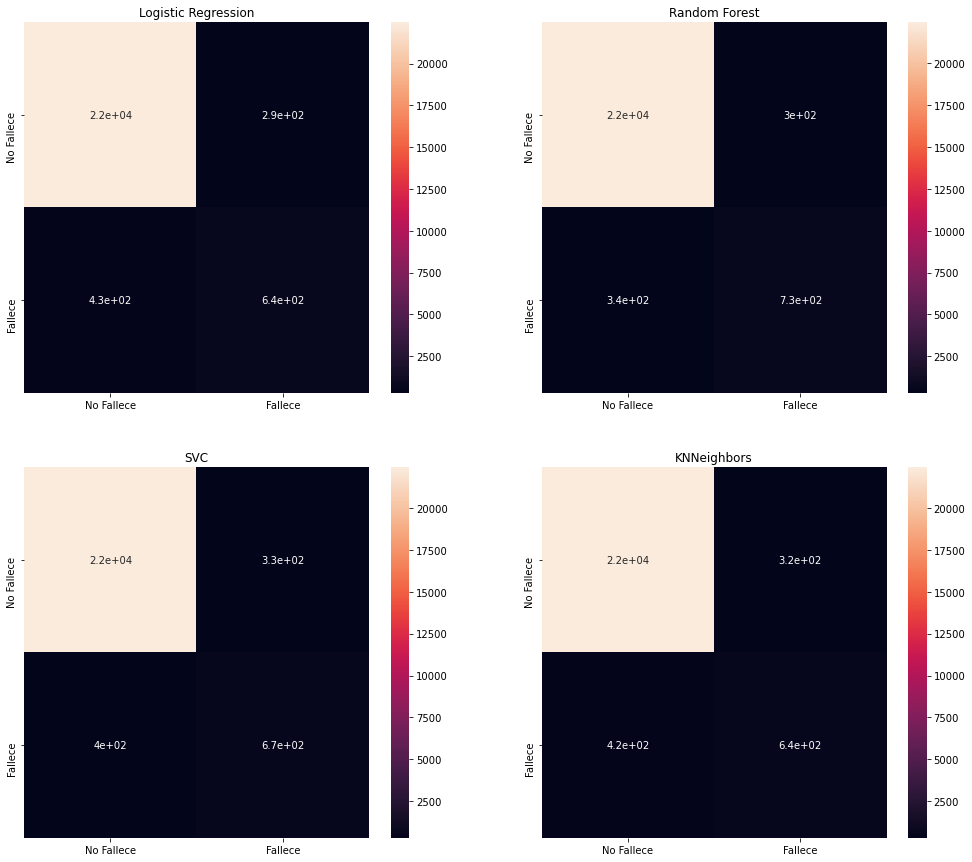

In [37]:
i = 0
names = ['Logistic Regression','Random Forest','SVC','KNNeighbors']

fig, axs = plt.subplots(2, 2, figsize=(17, 15))

for ax in axs.flat:
    cm = confusion_matrix(ytest, ypreds[names[i]])
    ax.set_title(f'{names[i]}')
    i += 1
    df_cm = pd.DataFrame(cm, index = ['No Fallece', 'Fallece'], columns = ['No Fallece', 'Fallece'])
    
    sns.heatmap(df_cm, ax=ax, annot=True)

## Interpretacion del mejor modelo - Random Forest

Usamos la libreria [SHAP](https://github.com/slundberg/shap) y graficamos la importancia de cada feature para nuestro modelo

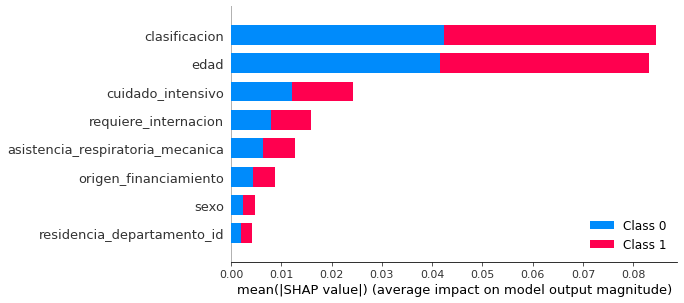

In [38]:
shap.initjs()

explainer = shap.TreeExplainer(m['Random Forest'])
shap_values = explainer.shap_values(xtrain)

shap.summary_plot(shap_values, xtrain, plot_type="bar")

Vemos como influyó cada feature en la toma de desicion de cada una de las primeras 100 predicciones

In [39]:
i = 100

# sample = np.array(xtrain.iloc[:i,:])
# print(m['Random Forest'].predict(sample))

shap.force_plot(explainer.expected_value[1], shap_values[1][:i,:], xtrain.iloc[:i,:])